In [1]:
import numpy as np
import pandas as pd

## Data Setup

In [2]:
import sys
# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
sys.path.append("../DNABERT/examples/data_process_template")
sys.path.append("../DNABERT/examples/")
sys.path.append("../DNABERT/src")
import process_690
import run_pretrain
import run_finetune

In [12]:
kmer = 6
#reads_path = '../MicrobiomeHD_data/autism_kb_results/autism_kb.otu_seqs.dbOTU.fasta'
#reads_path = '../MicrobiomeHD_data/ob_goodrich_results/ob_goodrich.otu_seqs.100.fasta'
reads_path = '../MicrobiomeHD_data/cdi_schubert_results/cdi_schubert.otu_seqs.dbOTU.fasta'
reads_ = pd.read_csv(reads_path, sep = ',', header = None)


# for the first reads_path
reads = pd.DataFrame(\
 {'label':reads_.iloc[range(reads_.shape[0])[::2]].reset_index()[0] ,\
  'elements':reads_.iloc[range(reads_.shape[0])[1::2]].reset_index()[0]
  })
reads['label'] = reads.label.str[1:]
reads.head()

# idx = np.arange(reads_.shape[0])[::4][:-1] + 1
# r = reads_[0][idx].reset_index()[0] + reads_[0][idx+1].reset_index()[0] + \
# reads_[0][idx+2].reset_index()[0]

# reads = pd.DataFrame([reads_[0][idx-1].str[1:].reset_index(drop = True), r]).transpose()
# reads.columns = ['label', 'elements']
# reads.head()

,label,elements
0,dbotu8913,TTCACCGTTGCCGGCGTACTCCCCAGGTGGAATACTTAATGCTTTC...
1,dbotu7799,TTTAACCTTGCGGCCGTACTCCCCAGGCGGTCGACTTAACGCGTTA...
2,dbotu7248,TTCAACCTTGCGGTCGTACTCCCCAGGCGGAGTGCTTAATGCGTTA...
3,dbotu4478,TTCACCGTTGCCGGCGTACTCCCCAGGTGGAATACTTAACGCTTTC...
4,dbotu7781,TTCACCGTTGCCGGCGTACTCCCCAGGTGGAATACTTAACGCTTTC...


In [14]:
reads.shape

(779, 2)

In [15]:
def kmerify(row):
    return(process_690.get_kmer_sentence( row.elements, kmer=6))


reads['kmers'] = reads.apply( kmerify, axis = 1 )

reads.head(2)
#process_690.get_kmer_sentence( reads.elements, kmer=6)

,label,elements,kmers
0,dbotu8913,TTCACCGTTGCCGGCGTACTCCCCAGGTGGAATACTTAATGCTTTC...,TTCACC TCACCG CACCGT ACCGTT CCGTTG CGTTGC GTTG...
1,dbotu7799,TTTAACCTTGCGGCCGTACTCCCCAGGCGGTCGACTTAACGCGTTA...,TTTAAC TTAACC TAACCT AACCTT ACCTTG CCTTGC CTTG...


In [16]:
import argparse
import glob
import logging
import os
import pickle
import random
import re
import shutil
from typing import Dict, List, Tuple
from copy import deepcopy
from multiprocessing import Pool

import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler

In [17]:
from transformers import (
    WEIGHTS_NAME,
    AdamW,
    BertModel,
    BertConfig,
    BertForMaskedLM,
    BertTokenizer,
    DNATokenizer,
    CamembertConfig,
    CamembertForMaskedLM,
    CamembertTokenizer,
    DistilBertConfig,
    DistilBertForMaskedLM,
    DistilBertTokenizer,
    GPT2Config,
    GPT2LMHeadModel,
    GPT2Tokenizer,
    OpenAIGPTConfig,
    OpenAIGPTLMHeadModel,
    OpenAIGPTTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    RobertaConfig,
    RobertaForMaskedLM,
    RobertaTokenizer,
    get_linear_schedule_with_warmup,
)

In [18]:
MODEL_CLASSES = {
    "gpt2": (GPT2Config, GPT2LMHeadModel, GPT2Tokenizer),
    "openai-gpt": (OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer),
    "dna": (BertConfig, BertForMaskedLM, DNATokenizer),
    "bert": (BertConfig, BertForMaskedLM, BertTokenizer),
    "roberta": (RobertaConfig, RobertaForMaskedLM, RobertaTokenizer),
    "distilbert": (DistilBertConfig, DistilBertForMaskedLM, DistilBertTokenizer),
    "camembert": (CamembertConfig, CamembertForMaskedLM, CamembertTokenizer),
}

In [411]:
config_class, model_class, tokenizer_class = MODEL_CLASSES['dna']

In [412]:
config = config_class.from_pretrained('../DNABERT_model_6/',\
                                      cache_dir='cache/')
config.output_hidden_states = True

In [21]:
tokenizer = tokenizer_class.from_pretrained('../DNABERT_model_6/',\
                                cache_dir='cache/')

<class 'transformers.tokenization_dna.DNATokenizer'>


In [418]:
model = BertModel.from_pretrained(  '../DNABERT_model_6',
            cache_dir= 'cache/',
            config = config)

In [23]:
from sbert_wk_functions import create_embeddings, generate_embedding

In [28]:
%%time
embeddings = create_embeddings(list(reads.kmers), model, tokenizer)

CPU times: user 3min 11s, sys: 9.15 s, total: 3min 20s
Wall time: 3min 10s


In [29]:
%%time
reads['idx'] = reads.index

CPU times: user 853 µs, sys: 974 µs, total: 1.83 ms
Wall time: 1.79 ms


In [31]:
#pd.read_csv('../MicrobiomeHD_data/autism_kb_results/autism_kb.otu_table.dbOTU', sep = '\t')
pd.read_csv('../MicrobiomeHD_data/cdi_schubert_results/cdi_schubert.otu_table.dbOTU', sep = '\t')

,Unnamed: 0,DA00006,DA00044,DA00065,DA00108,DA00153,DA00154,DA00155,DA00165,DA00170,...,HD7UIAO01.GD,HD7UIAO01.MOCK,HD9SPZN01.GD,HD9SPZN01.MOCK,HJKE73L01.GD,HJKE73L01.MOCK,HLFAWTL01.GD,HLFAWTL01.MOCK,HLFAWTL02.GD,HLFAWTL02.MOCK
0,dbotu8913,0,1,785,702,17,0,2,369,333,...,53,0,28,0,10,0,93,0,241,0
1,dbotu7799,407,0,5,1322,1,6,585,9,401,...,1,496,0,258,0,412,0,269,111,503
2,dbotu7248,119,622,0,0,14,29,6,2,0,...,0,9,0,7,0,8,0,5,10,9
3,dbotu4478,0,0,606,2,59,31,2,1,180,...,0,0,0,0,0,0,0,0,3,0
4,dbotu7781,0,0,502,0,33,0,2,71,94,...,0,2,0,1,0,0,1,2,446,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,dbotu14843,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
775,dbotu431,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
776,dbotu14917,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
777,dbotu3901,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
embeddings

array([[-0.0506149 ,  0.18237009, -0.08537982, ..., -0.11305264,
         0.14136743,  0.20873604],
       [-0.0873374 ,  0.17863269, -0.09776335, ..., -0.1159446 ,
         0.15984995,  0.32475527],
       [-0.04582948,  0.20363462, -0.16158285, ..., -0.09451766,
         0.11378315,  0.06951797],
       ...,
       [-0.13081802,  0.24861964, -0.15935318, ..., -0.0847213 ,
         0.14226459,  0.01543201],
       [-0.0960995 ,  0.18508735, -0.21283833, ..., -0.07482006,
         0.12973634,  0.08378181],
       [-0.13857634,  0.28429116,  0.03364766, ..., -0.1630679 ,
        -0.05113044,  0.12146598]])

In [33]:
n = len(embeddings)

sims = np.zeros((n, n))

#getting cosine similarities -- theres probably a good function for this...
for i in range(n):
    for j in range(i, n):
        sims[i,j] = embeddings[i].dot(embeddings[j])/ \
                    (np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[j]))

sims = sims + sims.T - np.eye(sims.shape[0])

In [34]:
sims.shape

(779, 779)

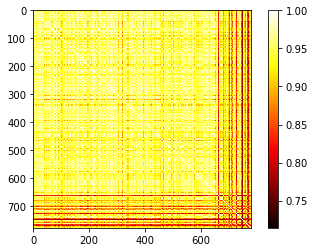

In [35]:
import matplotlib.pyplot as plt
plt.imshow(sims, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

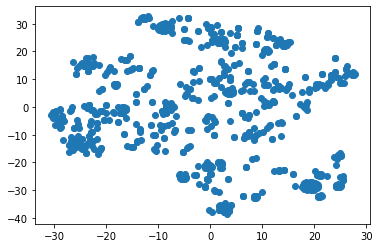

In [404]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pc = PCA(n_components = 100)
ts = TSNE(n_components = 2, perplexity = 30)

viz = ts.fit_transform( pc.fit_transform(embeddings) )
plt.scatter(viz[:,0], viz[:, 1])
plt.show()

In [36]:
from sklearn.cluster import AgglomerativeClustering as AC

In [37]:
n_dims = 200
dists = sims
cm = AC(n_clusters = n_dims, affinity = 'precomputed', linkage='average')
cm.fit(1 - dists)

AgglomerativeClustering(affinity='precomputed', linkage='average',
                        n_clusters=200)

In [38]:
def fix_df(df):
    df_fixed = df.transpose()
    df_fixed.columns = df_fixed.iloc[-1, ]
    df_fixed = df_fixed.drop( [df.columns[0]], axis = 0)
    #df_fixed = df_fixed.loc[ df_fixed.sum(axis = 1)>500 , ] 
    df_fixed = df_fixed.div(df_fixed.sum(axis=1), axis=0)
    df_fixed = df_fixed[list( df_fixed.columns.dropna() )]
    return(df_fixed)

In [39]:
# path = '../MicrobiomeHD_data/autism_kb_results/autism_kb.otu_table.dbOTU'
# path = '../MicrobiomeHD_data/ob_goodrich_results/autism_kb.otu_table.dbOTU'
path = '../MicrobiomeHD_data/cdi_schubert_results/cdi_schubert.otu_table.dbOTU'


df = pd.read_csv(path, sep = '\t')
df.index = df[df.columns[0]]
df_fixed = df.drop(df.columns[0], axis = 1).transpose()
df_fixed = df_fixed.div(df_fixed.sum(axis=1), axis=0)
df_fixed = df_fixed[list( df_fixed.columns.dropna() )]
df_fixed = df_fixed[[a for a in reads.label]]
df_fixed.head()

Unnamed: 0,dbotu8913,dbotu7799,dbotu7248,dbotu4478,dbotu7781,dbotu14876,dbotu13118,dbotu18794,dbotu18855,dbotu1345,...,dbotu15656,dbotu15978,dbotu16521,dbotu16531,dbotu17330,dbotu17429,dbotu17572,dbotu18353,dbotu18953,dbotu19580
DA00006,0.000000,0.277059,0.081007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DA00044,0.001038,0.000000,0.645898,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DA00065,0.263246,0.001677,0.000000,0.203219,0.168343,0.184105,0.000000,0.028840,0.000000,0.000671,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DA00108,0.267123,0.503044,0.000000,0.000761,0.000000,0.002283,0.012938,0.008752,0.003425,0.018265,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DA00153,0.006797,0.000400,0.005598,0.023591,0.013195,0.008796,0.000400,0.003199,0.041184,0.006797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
reads['cluster'] = cm.labels_
reads.head(2)

,label,elements,kmers,idx,cluster
0,dbotu8913,TTCACCGTTGCCGGCGTACTCCCCAGGTGGAATACTTAATGCTTTC...,TTCACC TCACCG CACCGT ACCGTT CCGTTG CGTTGC GTTG...,0,94
1,dbotu7799,TTTAACCTTGCGGCCGTACTCCCCAGGCGGTCGACTTAACGCGTTA...,TTTAAC TTAACC TAACCT AACCTT ACCTTG CCTTGC CTTG...,1,22


In [41]:
reads.columns

Index(['label', 'elements', 'kmers', 'idx', 'cluster'], dtype='object')

In [42]:
reduced = df_fixed.copy()
reduced.columns = reads.cluster
#reduced = reduced.transpose().groupby('cluster').sum().transpose()
red = reduced.transpose()
red['cluster'] = red.index
reduced = red.groupby('cluster').sum().transpose()
reduced.head()

ValueError: 'cluster' is both an index level and a column label, which is ambiguous.

In [43]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

In [53]:
# metadata_path = '../MicrobiomeHD_data/autism_kb_results/autism_kb.metadata.txt'
# metadata_path = '../MicrobiomeHD_data/ob_goodrich_results/ob_goodrich.metadata.txt'
metadata_path = '../MicrobiomeHD_data/cdi_schubert_results/cdi_schubert.metadata.txt'
# metadata_path = '../MicrobiomeHD_data/cdi_schubert_results/test_removal/new.txt'

In [56]:
pd.read_csv(metadata_path, sep = '\t', 
            encoding='latin1', error_bad_lines=False, warn_bad_lines=False)

,sample_id,submitted_to_insdc,investigation_type,project_name,experimental_factor,lat_lon,geo_loc_name,biome,feature,material,...,Surgery6mos,Vegetarian,ResidenceCdiff,weight,disease_stat,body_product,tot_mass,perturbation,samp_store_temp,DiseaseState
0,DA00006,F,metagenomic,Gut Microbiome and CDI,C. difficile & diarrheal status,42.282026 -83.733850,USA:Michigan:Ann Arbor,hospital,UniversityofMichigan,feces,...,yes,no,no,200-249,DiarrhealControl,feces,NaN,None,-20.0,nonCDI
1,DA00044,F,metagenomic,Gut Microbiome and CDI,C. difficile & diarrheal status,42.282026 -83.733850,USA:Michigan:Ann Arbor,hospital,UniversityofMichigan,feces,...,yes,no,no,Unknown,Case,feces,NaN,None,-20.0,CDI
2,DA00065,F,metagenomic,Gut Microbiome and CDI,C. difficile & diarrheal status,42.282026 -83.733850,USA:Michigan:Ann Arbor,hospital,UniversityofMichigan,feces,...,yes,no,no,Unknown,Case,feces,NaN,None,-20.0,CDI
3,DA00108,F,metagenomic,Gut Microbiome and CDI,C. difficile & diarrheal status,42.282026 -83.733850,USA:Michigan:Ann Arbor,hospital,UniversityofMichigan,feces,...,no,no,no,150-199,DiarrhealControl,feces,NaN,None,-20.0,nonCDI
4,DA00153,F,metagenomic,Gut Microbiome and CDI,C. difficile & diarrheal status,42.282026 -83.733850,USA:Michigan:Ann Arbor,hospital,UniversityofMichigan,feces,...,no,no,no,100-149,DiarrhealControl,feces,NaN,None,-20.0,nonCDI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,DA10184,F,metagenomic,Gut Microbiome and CDI,C. difficile & diarrheal status,42.282026 -83.733850,USA:Michigan:Ann Arbor,community,AnnArbor,feces,...,no,no,no,150-199,NonDiarrhealControl,feces,NaN,None,-20.0,H
333,DA10186,F,metagenomic,Gut Microbiome and CDI,C. difficile & diarrheal status,42.282026 -83.733850,USA:Michigan:Ann Arbor,community,AnnArbor,feces,...,no,no,no,100-149,NonDiarrhealControl,feces,NaN,None,-20.0,H
334,DA10187,F,metagenomic,Gut Microbiome and CDI,C. difficile & diarrheal status,42.282026 -83.733850,USA:Michigan:Ann Arbor,community,AnnArbor,feces,...,yes,no,no,>=250,NonDiarrhealControl,feces,NaN,None,-20.0,H
335,DA10188,F,metagenomic,Gut Microbiome and CDI,C. difficile & diarrheal status,42.282026 -83.733850,USA:Michigan:Ann Arbor,community,AnnArbor,feces,...,no,no,no,150-199,NonDiarrhealControl,feces,NaN,None,-20.0,H


In [59]:
metadata.columns

Index(['sample_id', 'submitted_to_insdc', 'investigation_type', 'project_name',
       'experimental_factor', 'lat_lon', 'geo_loc_name', 'biome', 'feature',
       'material', 'env_package', 'samp_collect_device', 'samp_mat_process',
       'samp_size', 'nucl_acid_ext', 'nucl_acid_amp', 'lib_reads_seqd',
       'lib_const_meth', 'target_gene', 'target_subfragment', 'sfffile_id',
       'pcr_primers', 'mid', 'adapters', 'pcr_cond', 'seq_meth',
       'seq_qual_check', 'chimera_check', 'url', 'sop', 'host_common_name',
       'age', 'race', 'gender', 'antibiotics >3mo', 'protonpump', 'h2receptor',
       'antacid', 'Healthworker', 'historyCdiff', 'Surgery6mos', 'Vegetarian',
       'ResidenceCdiff', 'weight', 'disease_stat', 'body_product', 'tot_mass',
       'perturbation', 'samp_store_temp', 'DiseaseState', 'Var'],
      dtype='object')

In [65]:
metadata.biome.value_counts()

hospital     183
community    154
Name: biome, dtype: int64

In [67]:
metadata = pd.read_csv(metadata_path, sep = '\t', encoding = 'latin1')

# metadata['Var'] = (metadata.body_mass_index >= 25) * 1
# metadata = metadata[[metadata.columns[0], 'Var']]
# metadata.columns = ['#Sample ID', 'Var']

# metadata['Var'] = metadata.DiseaseState
# metadata = metadata[['#Sample ID', 'Var']]
# metadata.head()

metadata['Var'] = metadata.biome
metadata['#Sample ID'] = metadata.sample_id
metadata = metadata[['#Sample ID', 'Var']]
metadata.head()

,#Sample ID,Var
0,DA00006,hospital
1,DA00044,hospital
2,DA00065,hospital
3,DA00108,hospital
4,DA00153,hospital


In [162]:
reads

,label,elements,kmers,idx,cluster
0,dbotu8913,TTCACCGTTGCCGGCGTACTCCCCAGGTGGAATACTTAATGCTTTC...,TTCACC TCACCG CACCGT ACCGTT CCGTTG CGTTGC GTTG...,0,35
1,dbotu7799,TTTAACCTTGCGGCCGTACTCCCCAGGCGGTCGACTTAACGCGTTA...,TTTAAC TTAACC TAACCT AACCTT ACCTTG CCTTGC CTTG...,1,0
2,dbotu7248,TTCAACCTTGCGGTCGTACTCCCCAGGCGGAGTGCTTAATGCGTTA...,TTCAAC TCAACC CAACCT AACCTT ACCTTG CCTTGC CTTG...,2,0
3,dbotu4478,TTCACCGTTGCCGGCGTACTCCCCAGGTGGAATACTTAACGCTTTC...,TTCACC TCACCG CACCGT ACCGTT CCGTTG CGTTGC GTTG...,3,0
4,dbotu7781,TTCACCGTTGCCGGCGTACTCCCCAGGTGGAATACTTAACGCTTTC...,TTCACC TCACCG CACCGT ACCGTT CCGTTG CGTTGC GTTG...,4,0
...,...,...,...,...,...
774,dbotu17429,TGGCCCACCTTTCCATTCAGTTTTAAGAAATCACCTTCACTTCATT...,TGGCCC GGCCCA GCCCAC CCCACC CCACCT CACCTT ACCT...,774,0
775,dbotu17572,GCAGCCAGGCAATTGTGGCCACAGGCTTTGGGTGAGTCCCAGTATT...,GCAGCC CAGCCA AGCCAG GCCAGG CCAGGC CAGGCA AGGC...,775,0
776,dbotu18353,TTCATTCTTGCGAACGTACTCCCCAGGTGGACTGCTTATTGCGTTT...,TTCATT TCATTC CATTCT ATTCTT TTCTTG TCTTGC CTTG...,776,0
777,dbotu18953,GTACCAAGTTCCGCTCTCTGGCTATACTGTTGGCGGCTTCCGTTGC...,GTACCA TACCAA ACCAAG CCAAGT CAAGTT AAGTTC AGTT...,777,0


In [237]:
from sklearn.linear_model import LogisticRegression

In [326]:
def test_reduced_dims(df_fixed, response, embeddings, n_dims, names):
    """
    reduces the dimensions by aggregating based on cluster similarity
    """
    cm = AC(n_clusters = n_dims, affinity = 'cosine', linkage='average')
    cm.fit(embeddings)
    names['cluster'] = cm.labels_
    
    reduced = df_fixed.copy()
    reduced.columns = names.cluster
    #reduced = reduced.transpose().groupby('cluster').sum().transpose()
    red = reduced.transpose()
    reduced = red.groupby(red.index).sum().transpose()

    reduced_resp = reduced.merge(response[['#Sample ID', 'Var']], \
                 how = 'inner', 
                 left_index = True, right_on = '#Sample ID').drop('#Sample ID', axis = 1)

    X = reduced_resp.drop('Var', axis = 1)
    #taking the less common class as the positive response
    y = reduced_resp.Var == pd.DataFrame( response.Var.value_counts() ).index[1]
    
    PREDS = []
    TRUES = []
    
    kf = KFold(n_splits=5, random_state=None, shuffle=True)
    X = X.reset_index(drop = True)
    y = y.reset_index(drop = True)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        try:
            y_train, y_test = y[train_index], y[test_index]
        except:
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        #rf = RandomForestClassifier(n_estimators = 100)
        rf = LogisticRegression(penalty = 'l1', solver = 'liblinear')
        rf.fit(X_train, y_train)
        clustered_rf_preds = rf.predict_proba(X_test)

        PREDS.append( clustered_rf_preds[:, 1] )
        TRUES.append( y_test )
        
    
    all_preds = np.concatenate(PREDS)
    all_trues = np.concatenate(TRUES)
        
    fpr, tpr, thresholds = roc_curve(all_trues, all_preds)

    auc_val = auc(fpr, tpr)
        
    return(fpr, tpr, auc_val, n_dims)

In [327]:
L = []

for i in [df_fixed.shape[1], 600, 500, 400, 300, 200, 100, 90, 80, 70, 60, 50]:
    L.append( test_reduced_dims(df_fixed, metadata, embeddings, i, reads) )

In [328]:
full_results = pd.concat([ pd.DataFrame.from_dict( 
    {'fpr':a[0], 
     'tpr':a[1], 
     'auc':[a[2]]*len(a[1]),
     'n_dims':[a[3]]*len(a[1]) } ) \
           for a in L ], axis = 0 )

full_results['Grouping Dimension'] = full_results.n_dims.astype(str) + ', AUC = ' \
                        + full_results.auc.astype(str).str[0:4]

/Users/george/anaconda2/envs/dnabert/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


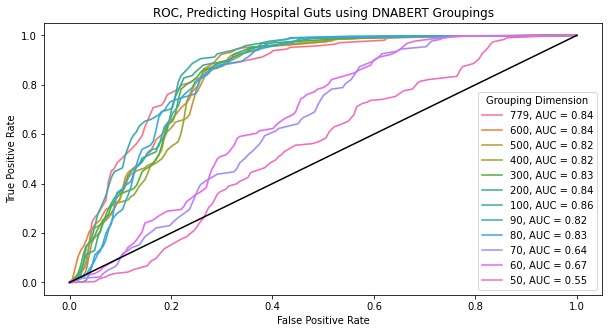

In [329]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.lineplot('fpr', 'tpr', 
             data = full_results,\
             ci= 0, hue = 'Grouping Dimension') 
plt.plot([0, 1], [0, 1], '-', color = 'black')
plt.title('ROC, Predicting Hospital Guts using DNABERT Groupings')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Mapping clusters to phylogeny, exploring the cases where the clusters differ, and how it relates to interpretable signals from logistic regression

In [330]:
reads.shape
len(embeddings)

779

In [331]:
phylos = pd.read_csv('../MicrobiomeHD_data/cdi_schubert_results/RDP/cdi_schubert.otu_table.dbOTU.rdp_assigned', sep = '\t')['Unnamed: 0']

In [332]:
phylos

0      k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...
1      k__Bacteria;p__Proteobacteria;c__Gammaproteoba...
2      k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...
3      k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...
4      k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...
                             ...                        
774    k__Bacteria;p__;c__;o__;f__;g__;s__;d__dbotu14843
775      k__Bacteria;p__;c__;o__;f__;g__;s__;d__dbotu431
776    k__Bacteria;p__;c__;o__;f__;g__;s__;d__dbotu14917
777     k__Bacteria;p__;c__;o__;f__;g__;s__;d__dbotu3901
778    k__Bacteria;p__;c__;o__;f__;g__;s__;d__dbotu15330
Name: Unnamed: 0, Length: 779, dtype: object

In [334]:
otu_phylo = pd.DataFrame( \
        dict( {'otu':phylos.str.replace(r';*[a-z]_+', ' ').str.replace(r' +', ' ').str.split(' ').str[-1], 
        'phylogeny':phylos.str.replace(r';*[a-z]_+', ' ').str.replace(r' +', ' ').str.split(' ').str[:-1].str.join(' ') } ) 
          )
otu_phylo

,otu,phylogeny
0,dbotu8913,Bacteria Bacteroidetes Bacteroidia Bacteroida...
1,dbotu7799,Bacteria Proteobacteria Gammaproteobacteria E...
2,dbotu7248,Bacteria Firmicutes Bacilli Lactobacillales E...
3,dbotu4478,Bacteria Bacteroidetes Bacteroidia Bacteroida...
4,dbotu7781,Bacteria Bacteroidetes Bacteroidia Bacteroida...
...,...,...
774,dbotu14843,Bacteria
775,dbotu431,Bacteria
776,dbotu14917,Bacteria
777,dbotu3901,Bacteria


In [335]:
otu_phylo.phylogeny.nunique()

156

In [336]:
reads.head()

,label,elements,kmers,idx,cluster
0,dbotu8913,TTCACCGTTGCCGGCGTACTCCCCAGGTGGAATACTTAATGCTTTC...,TTCACC TCACCG CACCGT ACCGTT CCGTTG CGTTGC GTTG...,0,1
1,dbotu7799,TTTAACCTTGCGGCCGTACTCCCCAGGCGGTCGACTTAACGCGTTA...,TTTAAC TTAACC TAACCT AACCTT ACCTTG CCTTGC CTTG...,1,1
2,dbotu7248,TTCAACCTTGCGGTCGTACTCCCCAGGCGGAGTGCTTAATGCGTTA...,TTCAAC TCAACC CAACCT AACCTT ACCTTG CCTTGC CTTG...,2,1
3,dbotu4478,TTCACCGTTGCCGGCGTACTCCCCAGGTGGAATACTTAACGCTTTC...,TTCACC TCACCG CACCGT ACCGTT CCGTTG CGTTGC GTTG...,3,1
4,dbotu7781,TTCACCGTTGCCGGCGTACTCCCCAGGTGGAATACTTAACGCTTTC...,TTCACC TCACCG CACCGT ACCGTT CCGTTG CGTTGC GTTG...,4,1


In [337]:

clusterer = model = AC(n_clusters=100,
                                    linkage="average", affinity='cosine')
clusterer.fit(embeddings)
reads['cluster'] = clusterer.labels_

In [338]:
merged_info = otu_phylo.merge(reads, how = 'inner', left_on = 'otu', right_on = 'label')[['otu', 'phylogeny', 'cluster']]

# Exploring significant elements in the lr models

In [339]:
# cm = AC(n_clusters = 100, affinity = 'cosine', linkage='average')
# cm.fit(embeddings)
# reads['cluster'] = cm.labels_

reduced = df_fixed.copy()
reduced.columns = reads.cluster
#reduced = reduced.transpose().groupby('cluster').sum().transpose()
red = reduced.transpose()
reduced = red.groupby(red.index).sum().transpose()

reduced_resp = reduced.merge(response[['#Sample ID', 'Var']], \
             how = 'inner', 
             left_index = True, right_on = '#Sample ID').drop('#Sample ID', axis = 1)

X = reduced_resp.drop('Var', axis = 1)
#taking the less common class as the positive response
y = reduced_resp.Var == pd.DataFrame( response.Var.value_counts() ).index[1]

PREDS = []
TRUES = []

kf = KFold(n_splits=5, random_state=None, shuffle=True)
X = X.reset_index(drop = True)
y = y.reset_index(drop = True)

rf = LogisticRegression(penalty = 'l1', solver = 'liblinear')
rf.fit(X, y)

LogisticRegression(penalty='l1', solver='liblinear')

In [340]:
merged_info

,otu,phylogeny,cluster
0,dbotu8913,Bacteria Bacteroidetes Bacteroidia Bacteroida...,14
1,dbotu7799,Bacteria Proteobacteria Gammaproteobacteria E...,7
2,dbotu7248,Bacteria Firmicutes Bacilli Lactobacillales E...,11
3,dbotu4478,Bacteria Bacteroidetes Bacteroidia Bacteroida...,14
4,dbotu7781,Bacteria Bacteroidetes Bacteroidia Bacteroida...,14
...,...,...,...
774,dbotu14843,Bacteria,55
775,dbotu431,Bacteria,64
776,dbotu14917,Bacteria,32
777,dbotu3901,Bacteria,50


In [341]:
test = merged_info.phylogeny[1:10]

In [342]:
dict( test.value_counts() )

{' Bacteria Bacteroidetes Bacteroidia Bacteroidales Bacteroidaceae Bacteroides': 4,
 ' Bacteria Firmicutes Clostridia Clostridiales Ruminococcaceae Faecalibacterium': 1,
 ' Bacteria Bacteroidetes Bacteroidia Bacteroidales Porphyromonadaceae Parabacteroides': 1,
 ' Bacteria Proteobacteria Gammaproteobacteria Enterobacteriales Enterobacteriaceae': 1,
 ' Bacteria Bacteroidetes Bacteroidia Bacteroidales Rikenellaceae Alistipes': 1,
 ' Bacteria Firmicutes Bacilli Lactobacillales Enterococcaceae Enterococcus': 1}

In [343]:
cluster_summaries = merged_info.groupby('cluster')['phylogeny'].agg(lambda x: dict(x.value_counts())).reset_index()

In [344]:
otu_phylo

,otu,phylogeny
0,dbotu8913,Bacteria Bacteroidetes Bacteroidia Bacteroida...
1,dbotu7799,Bacteria Proteobacteria Gammaproteobacteria E...
2,dbotu7248,Bacteria Firmicutes Bacilli Lactobacillales E...
3,dbotu4478,Bacteria Bacteroidetes Bacteroidia Bacteroida...
4,dbotu7781,Bacteria Bacteroidetes Bacteroidia Bacteroida...
...,...,...
774,dbotu14843,Bacteria
775,dbotu431,Bacteria
776,dbotu14917,Bacteria
777,dbotu3901,Bacteria


In [346]:
cluster_summaries['coef'] = rf.coef_[0]

In [348]:
for i in cluster_summaries.loc[cluster_summaries.coef != 0].index:
    print(cluster_summaries.phylogeny[i])
    print(cluster_summaries.coef[i])

{' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae': 21, ' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae Blautia': 10, ' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae Ruminococcus2': 8, ' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae Roseburia': 5, ' Bacteria Firmicutes Clostridia Clostridiales': 4, ' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae Coprococcus': 3, ' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae Clostridiu XlVa': 2, ' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae Lachnospirace incerta sedis': 2, ' Bacteria Firmicutes Erysipelotrichia Erysipelotrichales Erysipelotrichaceae Catenibacterium': 1, ' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae Anaerostipes': 1}
-0.8580436249989677
{' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae': 8, ' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae Clostridiu XlVa': 4, ' Bacteria Firmicutes Clostr

# exploring logistic regression results when grouping by phylogenetic assignment

In [393]:
merged_info.phylogeny.str.split(' ').str[:6].str.join(' ').value_counts()

 Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae                      145
 Bacteria                                                                           73
 Bacteria Bacteroidetes Bacteroidia Bacteroidales Porphyromonadaceae                56
 Bacteria Bacteroidetes Bacteroidia Bacteroidales Bacteroidaceae                    53
 Bacteria Firmicutes Clostridia Clostridiales Ruminococcaceae                       52
                                                                                  ... 
 Bacteria Proteobacteria Gammaproteobacteria Pseudomonadales Moraxellaceae           1
 Bacteria Proteobacteria Alphaproteobacteria Sphingomonadales Sphingomonadaceae      1
 Bacteria Proteobacteria Gammaproteobacteria Alteromonadales Shewanellaceae          1
 Bacteria Spirochaetes Spirochaetia Spirochaetales Spirochaetaceae                   1
 Bacteria Proteobacteria Alphaproteobacteria Rhizobiales Phyllobacteriaceae          1
Name: phylogeny, Length: 83, dtype: int64

In [369]:
def test_reduce_by_phylo_name(df_fixed, response, n_cutoffs,  names):
    cluster = names.phylogeny.str.split(' ').str[:n_cutoffs].str.join(' ')


    reduced = df_fixed.copy()
    reduced.columns = cluster
    reduced = reduced.transpose().groupby('phylogeny').sum().transpose()
    reduced_resp = reduced.merge(response[['#Sample ID', 'Var']], \
                 how = 'inner', 
                 left_index = True, right_on = '#Sample ID').drop('#Sample ID', axis = 1)

    X = reduced_resp.drop('Var', axis = 1)
    print(n_cutoffs, X.shape)
    #taking the less common class as the positive response
    y = reduced_resp.Var == pd.DataFrame( response.Var.value_counts() ).index[1]

    #doing K-Fold cross validation, to get 100+ predictions

    #     X_train, X_test, y_train, y_test = train_test_split(\
    #                         X, y, test_size=0.15, random_state=42)
    
    PREDS = []
    TRUES = []
    
    kf = KFold(n_splits=5, random_state=0, shuffle=True)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        #rf = RandomForestClassifier(n_estimators = 100)
        rf = LogisticRegression(penalty = 'l1', solver = 'liblinear')
        rf.fit(X_train, y_train)
        clustered_rf_preds = rf.predict_proba(X_test)

        PREDS.append( clustered_rf_preds[:, 1] )
        TRUES.append( y_test )

    all_preds = np.concatenate(PREDS)
    all_trues = np.concatenate(TRUES)

    fpr, tpr, thresholds = roc_curve(all_trues, all_preds)

    auc_val = auc(fpr, tpr)

    return(fpr, tpr, auc_val, X.shape[1] )

1 (336, 1)
2 (336, 3)
3 (336, 16)
5 (336, 51)
6 (336, 83)
7 (336, 149)
20 (336, 156)


/Users/george/anaconda2/envs/dnabert/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


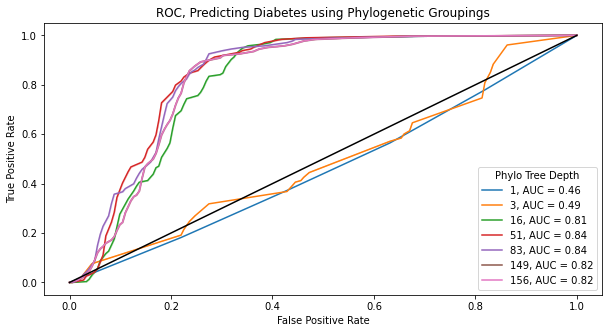

In [371]:
G = []
for i in [1, 2, 3, 5, 6, 7, 20]:
    G.append( test_reduce_by_phylo_name(df_fixed, response, i, otu_phylo) )
    
    
phylo_results = pd.concat([ pd.DataFrame.from_dict( 
    {'fpr':a[0], 
     'tpr':a[1], 
     'auc':[a[2]]*len(a[1]),
     'n_cutoffs':[a[3]]*len(a[1]) } ) \
           for a in G ], axis = 0 )

phylo_results['Phylo Tree Depth'] = phylo_results.n_cutoffs.astype(str) + ', AUC = ' \
                        + phylo_results.auc.astype(str).str[0:4]


plt.figure(figsize=(10,5))
sns.lineplot('fpr', 'tpr', 
             data = phylo_results,\
             ci= 0, hue = 'Phylo Tree Depth') 
plt.plot([0, 1], [0, 1], '-', color = 'black')
plt.title('ROC, Predicting Diabetes using Phylogenetic Groupings')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [373]:
n_cutoffs = 5
cluster = merged_info.phylogeny.str.split(' ').str[:n_cutoffs].str.join(' ')


reduced = df_fixed.copy()
reduced.columns = cluster
reduced = reduced.transpose().groupby('phylogeny').sum().transpose()
reduced_resp = reduced.merge(response[['#Sample ID', 'Var']], \
             how = 'inner', 
             left_index = True, right_on = '#Sample ID').drop('#Sample ID', axis = 1)

X = reduced_resp.drop('Var', axis = 1)
print(n_cutoffs, X.shape)
#taking the less common class as the positive response
y = reduced_resp.Var == pd.DataFrame( response.Var.value_counts() ).index[1]

rf = LogisticRegression(penalty = 'l1', solver = 'liblinear')
rf.fit(X, y)

5 (336, 51)


LogisticRegression(penalty='l1', solver='liblinear')

In [386]:
phylo_group_results = pd.DataFrame(dict({ 'phylo':reduced.columns, 
                     'coef':rf.coef_[0] }))

for i in phylo_group_results.loc[phylo_group_results.coef != 0].index:
    print(phylo_group_results.phylo[i])
    print(phylo_group_results.coef[i])

#rf.coef_

 Bacteria Bacteroidetes Bacteroidia Bacteroidales
3.0689667220644252
 Bacteria Firmicutes Bacilli Lactobacillales
-4.8493951073629935
 Bacteria Firmicutes Negativicutes Selenomonadales
7.4513936535395375
 Bacteria Proteobacteria Gammaproteobacteria Enterobacteriales
-3.141657285854404


In [387]:
for i in cluster_summaries.loc[cluster_summaries.coef != 0].index:
    print(cluster_summaries.phylogeny[i])
    print(cluster_summaries.coef[i])

{' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae': 21, ' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae Blautia': 10, ' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae Ruminococcus2': 8, ' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae Roseburia': 5, ' Bacteria Firmicutes Clostridia Clostridiales': 4, ' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae Coprococcus': 3, ' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae Clostridiu XlVa': 2, ' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae Lachnospirace incerta sedis': 2, ' Bacteria Firmicutes Erysipelotrichia Erysipelotrichales Erysipelotrichaceae Catenibacterium': 1, ' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae Anaerostipes': 1}
-0.8580436249989677
{' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae': 8, ' Bacteria Firmicutes Clostridia Clostridiales Lachnospiraceae Clostridiu XlVa': 4, ' Bacteria Firmicutes Clostr

## to-dos:
- organize this work on predicting hospital guts into a notebook (it is pretty interesting)
- read more about the study where this study is coming from
- find 1-2 more studies where I can dive into the results
- potentially investigate the groupings using embeddings based on the phylogenetic names
- focus on the areas where the phylogenetic assignment isn't enough. the differing signals in coefficient + same phylo is very relevant for this project.